In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, MaxPool2D, LSTM, GRU

In [2]:
df = pd.read_csv("dataset/Video Information Extraction.csv")

In [3]:
df.head()

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book


We need to remove the identity of the unpreserved video

In [4]:
record = pickle.load(open("final_record_cleaned.pkl", "rb"))

In [5]:
video_id_kept = list(record.keys())
video_id_kept = [int(id.replace('.mp4', '')) for id in video_id_kept]

In [6]:
new_df = df[df["video_id"].isin(video_id_kept)]

In [7]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
8,25,-1,1,11,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,17710,196,15,521,414,drink
12,25,-1,1,19,52,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,17711,289,9,783,480,drink
14,25,-1,1,21,21,asldeafined,test,https://media.asldeafined.com/vocabulary/14677...,0,17713,28,0,542,480,drink
15,25,-1,1,27,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,0,17709,41,9,257,240,drink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11968,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/7/7474.mp4,0,62492,69,16,219,192,waterfall
11969,25,-1,1,6,12,aslsearch,train,http://www.aslsearch.com/signs/videos/waterfal...,0,62493,203,55,549,400,waterfall
11970,25,-1,1,3,19,elementalasl,train,https://elementalaslconcepts.weebly.com/upload...,0,62782,89,4,242,180,weigh
11973,25,-1,1,2,4,signschool,test,https://signstock.blob.core.windows.net/signsc...,0,63044,415,86,1811,1080,wheelchair


Reordering dataframe

In [8]:
new_df = new_df.sort_values(by=["video_id"]) 

In [9]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
8751,25,-1,1,2,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,335,57,5,246,240,abdomen
8752,25,-1,1,3,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14688...,0,336,103,0,565,480,abdomen
8756,25,-1,1,1,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,376,61,5,247,240,able
8757,25,-1,1,2,15,asldeafined,train,https://media.asldeafined.com/vocabulary/14667...,0,377,69,17,552,480,able
1709,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,414,64,27,241,240,about
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
7446,25,-1,1,1,116,aslbrick,train,http://aslbricks.org/New/ASL-Videos/worm.mp4,0,69541,282,4,937,720,worm
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

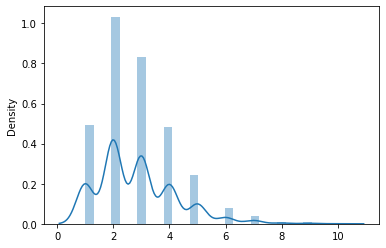

In [10]:
sns.distplot(np.array(new_df["gloss"].value_counts()))

Easy mode : Removing classes with less than 3 element

In [11]:
val_count = dict(new_df["gloss"].value_counts())

In [12]:
single_classes = [key for key in val_count.keys() if val_count[key] < 3]

In [13]:
len(single_classes)

925

In [14]:
new_df = new_df[~new_df["gloss"].isin(single_classes)]

In [15]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
3916,25,-1,1,4,26,spreadthesign,val,https://media.spreadthesign.com/video/mp4/13/9...,0,592,81,40,272,240,accept
3918,25,-1,1,6,6,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,594,512,107,1397,1080,accept
3917,25,-1,1,5,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14661...,0,597,96,17,624,480,accept
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
7446,25,-1,1,1,116,aslbrick,train,http://aslbricks.org/New/ASL-Videos/worm.mp4,0,69541,282,4,937,720,worm
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow


Reordering records

In [16]:
sorted_record = { key : record[key] for key in sorted(record.keys()) if int(key.replace(".mp4", "")) in list(new_df["video_id"])}

In [17]:
len(sorted_record)

3981

## Prepare dataset

In [18]:
X = np.array(list(sorted_record.values()))

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(np.array(list(new_df["gloss"])).reshape(-1,1))
y = encoder.transform(np.array(list(new_df["gloss"])).reshape(-1,1)).toarray()

In [19]:
le = LabelEncoder()
y_ = le.fit_transform(np.array(list(new_df["gloss"])))

In [20]:
y_.shape

(3981,)

In [21]:
print(X.shape, y.shape)

(3981, 520, 100, 3) (3981, 1030)


In [22]:
X = X.reshape(X.shape[0], X.shape[2], X.shape[1], X.shape[3])

In [23]:
input_dim = X.shape[1:]
nb_classes = y.shape[-1]

## Model implementation

In [ ]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model.add(tf.keras.layers.Reshape((100, 65*32)))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 260, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 130, 16)      38416     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 65, 32)       4640      
                                                                 
 reshape (Reshape)           (None, 100, 2080)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                549120    
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1030)              1

In [30]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

Epoch 1/10
44/44 [==============================] - 157s 4s/step - loss: 6.9458 - accuracy: 0.0061 - val_loss: 6.9569 - val_accuracy: 0.0017
Epoch 2/10
44/44 [==============================] - 157s 4s/step - loss: 6.7683 - accuracy: 0.0129 - val_loss: 7.0101 - val_accuracy: 0.0025
Epoch 3/10
44/44 [==============================] - 155s 4s/step - loss: 6.5435 - accuracy: 0.0162 - val_loss: 7.1347 - val_accuracy: 0.0025
Epoch 4/10
44/44 [==============================] - 156s 4s/step - loss: 6.2503 - accuracy: 0.0219 - val_loss: 7.3118 - val_accuracy: 0.0042
Epoch 5/10
44/44 [==============================] - 154s 4s/step - loss: 5.9300 - accuracy: 0.0363 - val_loss: 7.5284 - val_accuracy: 0.0033
Epoch 6/10
44/44 [==============================] - 155s 4s/step - loss: 5.6104 - accuracy: 0.0431 - val_loss: 7.7861 - val_accuracy: 0.0025
Epoch 7/10
44/44 [==============================] - 154s 4s/step - loss: 5.3697 - accuracy: 0.0567 - val_loss: 8.0642 - val_accuracy: 0.0025
Epoch 8/10
44

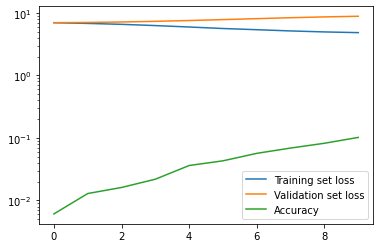

Epoch 1/10
44/44 [==============================] - 158s 4s/step - loss: 5.9105 - accuracy: 0.0811 - val_loss: 6.0998 - val_accuracy: 0.0720
Epoch 2/10
44/44 [==============================] - 156s 4s/step - loss: 5.6199 - accuracy: 0.0976 - val_loss: 6.1924 - val_accuracy: 0.0494
Epoch 3/10
44/44 [==============================] - 155s 4s/step - loss: 5.4276 - accuracy: 0.1030 - val_loss: 6.3185 - val_accuracy: 0.0293
Epoch 4/10
44/44 [==============================] - 154s 4s/step - loss: 5.2385 - accuracy: 0.1195 - val_loss: 6.4084 - val_accuracy: 0.0285
Epoch 5/10
44/44 [==============================] - 155s 4s/step - loss: 5.1494 - accuracy: 0.1242 - val_loss: 6.5566 - val_accuracy: 0.0184
Epoch 6/10
44/44 [==============================] - 160s 4s/step - loss: 5.0094 - accuracy: 0.1328 - val_loss: 6.7179 - val_accuracy: 0.0084
Epoch 7/10
44/44 [==============================] - 154s 4s/step - loss: 4.8730 - accuracy: 0.1468 - val_loss: 6.7891 - val_accuracy: 0.0109
Epoch 8/10
44

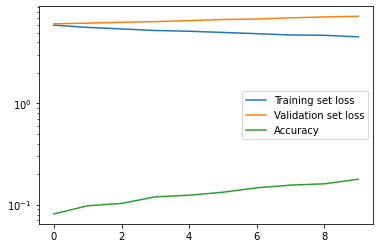

Epoch 1/10
44/44 [==============================] - 206s 5s/step - loss: 5.2865 - accuracy: 0.1360 - val_loss: 5.3884 - val_accuracy: 0.1172
Epoch 2/10
44/44 [==============================] - 211s 5s/step - loss: 5.0419 - accuracy: 0.1493 - val_loss: 5.5796 - val_accuracy: 0.0753
Epoch 3/10
44/44 [==============================] - 195s 4s/step - loss: 4.8955 - accuracy: 0.1587 - val_loss: 5.7359 - val_accuracy: 0.0636
Epoch 4/10
44/44 [==============================] - 195s 4s/step - loss: 4.7200 - accuracy: 0.1734 - val_loss: 5.8704 - val_accuracy: 0.0527
Epoch 5/10
44/44 [==============================] - 196s 4s/step - loss: 4.6080 - accuracy: 0.1823 - val_loss: 5.9892 - val_accuracy: 0.0444
Epoch 6/10
44/44 [==============================] - 194s 4s/step - loss: 4.4595 - accuracy: 0.1874 - val_loss: 6.1331 - val_accuracy: 0.0393
Epoch 7/10
44/44 [==============================] - 194s 4s/step - loss: 4.3307 - accuracy: 0.2046 - val_loss: 6.2661 - val_accuracy: 0.0285
Epoch 8/10
44

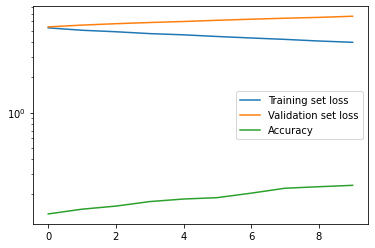

Epoch 1/10
44/44 [==============================] - 203s 5s/step - loss: 4.7554 - accuracy: 0.1917 - val_loss: 4.8095 - val_accuracy: 0.1590
Epoch 2/10
44/44 [==============================] - 196s 4s/step - loss: 4.5172 - accuracy: 0.2114 - val_loss: 5.0224 - val_accuracy: 0.1255
Epoch 3/10
44/44 [==============================] - 193s 4s/step - loss: 4.3751 - accuracy: 0.2089 - val_loss: 5.1855 - val_accuracy: 0.1021
Epoch 4/10
44/44 [==============================] - 194s 4s/step - loss: 4.2319 - accuracy: 0.2312 - val_loss: 5.3138 - val_accuracy: 0.0837
Epoch 5/10
44/44 [==============================] - 169s 4s/step - loss: 4.1782 - accuracy: 0.2218 - val_loss: 5.4555 - val_accuracy: 0.0745
Epoch 6/10
44/44 [==============================] - 161s 4s/step - loss: 4.0806 - accuracy: 0.2308 - val_loss: 5.6153 - val_accuracy: 0.0678
Epoch 7/10
44/44 [==============================] - 169s 4s/step - loss: 3.9695 - accuracy: 0.2502 - val_loss: 5.7323 - val_accuracy: 0.0477
Epoch 8/10
44

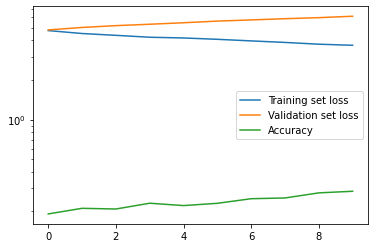

Epoch 1/10
44/44 [==============================] - 177s 4s/step - loss: 4.3633 - accuracy: 0.2182 - val_loss: 4.4601 - val_accuracy: 0.2075
Epoch 2/10
44/44 [==============================] - 164s 4s/step - loss: 4.1688 - accuracy: 0.2373 - val_loss: 4.6518 - val_accuracy: 0.1699
Epoch 3/10
44/44 [==============================] - 161s 4s/step - loss: 3.9876 - accuracy: 0.2487 - val_loss: 4.7752 - val_accuracy: 0.1490
Epoch 4/10
44/44 [==============================] - 169s 4s/step - loss: 3.8285 - accuracy: 0.2739 - val_loss: 4.9087 - val_accuracy: 0.1297
Epoch 5/10
44/44 [==============================] - 169s 4s/step - loss: 3.7385 - accuracy: 0.2872 - val_loss: 5.1094 - val_accuracy: 0.1088
Epoch 6/10
44/44 [==============================] - 164s 4s/step - loss: 3.7000 - accuracy: 0.2832 - val_loss: 5.2891 - val_accuracy: 0.0921
Epoch 7/10
44/44 [==============================] - 168s 4s/step - loss: 3.6121 - accuracy: 0.2947 - val_loss: 5.4448 - val_accuracy: 0.0795
Epoch 8/10
44

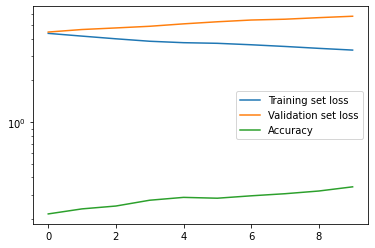

In [30]:
for train_index, test_index in sss.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [31]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

125/125 [==============================] - 36s 282ms/step


In [32]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.31895924822595473
Accuracy :  0.30419492589801556
Precision score :  0.41293071704964746
Recall score :  0.30419492589801556


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training only with hands landmarks

In [24]:
X2 = X[:,:,:42]

In [25]:
input_dim_2 = X2.shape[1:]

In [27]:
model2 = Sequential()
model2.add(Input(shape=(input_dim_2)))
model2.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model2.add(tf.keras.layers.Reshape((100, 6*32)))
model2.add(LSTM(64))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 21, 8)        224       
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 11, 16)       38416     
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 6, 32)        4640      
                                                                 
 reshape_1 (Reshape)         (None, 100, 192)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                65792     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1030)             

In [31]:
for train_index, test_index in sss.split(X2, y_):
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model2.history.history['loss'])
    plt.plot(model2.history.history['val_loss'])
    plt.plot(model2.history.history['accuracy'])
    plt.plot(model2.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

Epoch 1/10
44/44 [==============================] - 41s 809ms/step - loss: 6.9529 - accuracy: 0.0014 - val_loss: 6.9421 - val_accuracy: 0.0017
Epoch 2/10
21/44 [=============>................] - ETA: 15s - loss: 6.8705 - accuracy: 0.0037


KeyboardInterrupt



In [56]:
y_pred = model2.predict(X2)         
y_pred = np.argmax(y_pred, axis = 1)

125/125 [==============================] - 8s 59ms/step


In [57]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.19501868653081791
Accuracy :  0.16930419492589802
Precision score :  0.3207483299904223
Recall score :  0.16930419492589802


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Less complicated architecture

In [80]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(tf.keras.layers.Reshape((100, 520*3)))
model.add(LSTM(128))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 100, 1560)         0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               864768    
                                                                 
 dense_12 (Dense)            (None, 1030)              132870    
                                                                 
Total params: 997,638
Trainable params: 997,638
Non-trainable params: 0
_________________________________________________________________


In [82]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

In [83]:
for train_index, test_index in sss.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

Epoch 1/10
44/44 [==============================] - 29s 504ms/step - loss: 6.9783 - accuracy: 3.5894e-04 - val_loss: 6.9394 - val_accuracy: 0.0033
Epoch 2/10
44/44 [==============================] - 19s 439ms/step - loss: 6.9060 - accuracy: 0.0036 - val_loss: 6.9440 - val_accuracy: 0.0000e+00
Epoch 3/10
44/44 [==============================] - 16s 368ms/step - loss: 6.8546 - accuracy: 0.0194 - val_loss: 6.9546 - val_accuracy: 8.3682e-04
Epoch 4/10
44/44 [==============================] - 15s 335ms/step - loss: 6.7831 - accuracy: 0.0327 - val_loss: 6.9736 - val_accuracy: 0.0025
Epoch 5/10
44/44 [==============================] - 15s 344ms/step - loss: 6.7061 - accuracy: 0.0456 - val_loss: 7.0020 - val_accuracy: 0.0033
Epoch 6/10
 3/44 [=>............................] - ETA: 11s - loss: 6.6015 - accuracy: 0.0521


KeyboardInterrupt



In [31]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

125/125 [==============================] - 36s 282ms/step


In [32]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.31895924822595473
Accuracy :  0.30419492589801556
Precision score :  0.41293071704964746
Recall score :  0.30419492589801556


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
